# Atelier 4 - Influence du modèle

## 🎯 But pédagogique  


### ⚙️ Impact du modèle






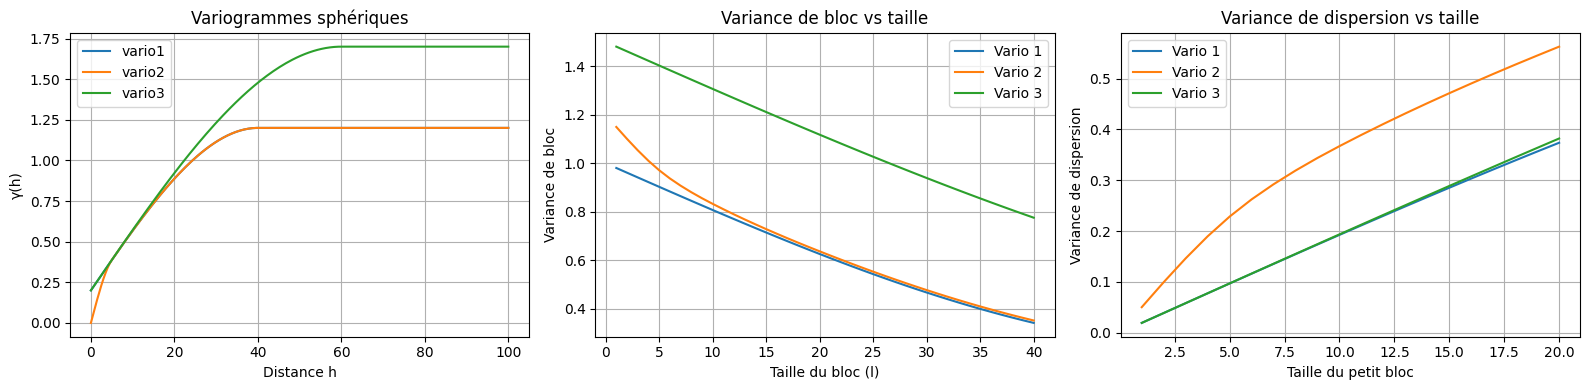

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.legendre import leggauss

# --- Modèles de covariance ---
def spherical_covariance(h, range_, sill):
    cov = np.zeros_like(h)
    mask = h <= range_
    hr = h[mask] / range_
    cov[mask] = sill * (1 - 1.5 * hr + 0.5 * hr**3)
    return cov

def spherical_variogram(h, nugget, sill, range_):
    return nugget + (sill - nugget) * (1.5 * (h / range_) - 0.5 * (h / range_)**3) * (h <= range_) + (sill - nugget) * (h > range_)

def nested_spherical_variogram(h, nugget, sill1, range1, sill2, range2):
    # somme des deux variogrammes sphériques + nugget
    gamma1 = spherical_variogram(h, 0, sill1, range1)
    gamma2 = spherical_variogram(h, 0, sill2, range2)
    return nugget + gamma1 + gamma2

# Covariance imbriquée pour la variance de bloc
def nested_spherical_covariance(h, sill1, range1, sill2, range2):
    # somme des covariances (car covariance = sill - variogramme)
    cov1 = spherical_covariance(h, range1, sill1)
    cov2 = spherical_covariance(h, range2, sill2)
    return cov1 + cov2

# --- Variance de bloc par quadrature (surface) ---
def block_variance_surface(lx, ly, model, n_points=5):
    pts_1D, w_1D = leggauss(n_points)
    pts_1D = 0.5 * (pts_1D + 1)
    w_1D = 0.5 * w_1D

    X, Y = np.meshgrid(pts_1D * lx, pts_1D * ly)
    points = np.column_stack([X.ravel(), Y.ravel()])
    weights = np.outer(w_1D, w_1D).ravel()

    diff = (points[:, None, :] - points[None, :, :])

    if model['type'] == 'spherical':
        range_x = model['range']
        range_y = model['range']
        h = np.linalg.norm(diff / np.array([range_x, range_y]), axis=2)
        cov_mat = spherical_covariance(h, 1.0, model['sill'] - model['nugget'])
    elif model['type'] == 'nested':
        range_x1, range_y1 = model['range1'], model['range1']
        range_x2, range_y2 = model['range2'], model['range2']
        h1 = np.linalg.norm(diff / np.array([range_x1, range_y1]), axis=2)
        h2 = np.linalg.norm(diff / np.array([range_x2, range_y2]), axis=2)
        cov1 = spherical_covariance(h1, 1.0, model['sill1'])
        cov2 = spherical_covariance(h2, 1.0, model['sill2'])
        cov_mat = cov1 + cov2
    else:
        raise NotImplementedError("Modèle non supporté.")

    return np.sum(weights[:, None] * weights[None, :] * cov_mat)


# --- Paramètres des variogrammes ---
variogrammes = [
    {"type": "spherical", "nugget": 0.2, "sill": 1.2, "range": 40},
    {"type": "nested", "nugget": 0.0, "sill1": 0.2, "range1": 5, "sill2": 1.0, "range2": 40},
    {"type": "spherical", "nugget": 0.2, "sill": 1.7, "range": 60},
]

# --- Figure 1 : Variogrammes ---
h_vals = np.linspace(0, 100, 200)
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)

for i, v in enumerate(variogrammes):
    if v['type'] == 'spherical':
        gamma = spherical_variogram(h_vals, v['nugget'], v['sill'], v['range'])
    elif v['type'] == 'nested':
        gamma = nested_spherical_variogram(h_vals, v['nugget'], v['sill1'], v['range1'], v['sill2'], v['range2'])
    plt.plot(h_vals, gamma, label=f"vario{i+1}")

plt.xlabel("Distance h")
plt.ylabel("γ(h)")
plt.title("Variogrammes sphériques")
plt.grid(True)
plt.legend()

# --- Figure 2 : Variance de bloc pour taille 1 à 40 ---
plt.subplot(1, 3, 2)
l_vals = np.arange(1, 41)
for i, v in enumerate(variogrammes):
    var_blocs = [block_variance_surface(l, l, model=v, n_points=5) for l in l_vals]
    plt.plot(l_vals, var_blocs, label=f"Vario {i+1}")

plt.xlabel("Taille du bloc (l)")
plt.ylabel("Variance de bloc")
plt.title("Variance de bloc vs taille")
plt.grid(True)
plt.legend()

# --- Figure 3 : Variance de dispersion = Var(point) - Var(bloc_l) ---
plt.subplot(1, 3, 3)
l_vals_disp = np.arange(1, 21)
for i, v in enumerate(variogrammes):
    var_point = block_variance_surface(0, 0, model=v, n_points=1)
    var_blocs = [block_variance_surface(l, l, model=v, n_points=5) for l in l_vals_disp]
    dispersion = var_point - np.array(var_blocs)
    plt.plot(l_vals_disp, dispersion, label=f"Vario {i+1}")

plt.xlabel("Taille du petit bloc")
plt.ylabel("Variance de dispersion")
plt.title("Variance de dispersion vs taille")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
